# babi task  project
GD 노드 14

프로세스는 다음과 같다.
1. 데이터 로드 및 전처리
2. 모델링
3. 모델 훈련
4. 모델 평가

## 1. 데이터 로드 및 전처리

In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re

In [2]:
# 환경에 맞게 경로 수정
home_dir = os.getenv('HOME')+'/aiffel/babi_memory_net'

In [3]:
# 환경에 맞게 경로 적절히 수정
DATA_DIR = home_dir
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test_kor.txt")

In [4]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


### 데이터 분할
스토리, 질문, 답변으로 데이터를 분할한다.

In [5]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [6]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [7]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [8]:
print("train 스토리 개수:", len(train_stories))
print("train 질문 개수:", len(train_questions))
print("train 답변 개수:", len(train_answers))
print("test 스토리 개수:", len(test_stories))
print("test 질문 개수:", len(test_questions))
print("test 답변 개수:", len(test_answers))

train 스토리 개수: 10000
train 질문 개수: 10000
train 답변 개수: 10000
test 스토리 개수: 1000
test 질문 개수: 1000
test 답변 개수: 1000


In [9]:
train_stories[3878]

['수종이는 화장실로 뛰어갔습니다.',
 '경임이는 사무실로 갔습니다.',
 '은경이는 부엌으로 이동했습니다.',
 '경임이는 화장실로 갔습니다.',
 '수종이는 복도로 갔습니다.',
 '필웅이는 부엌으로 가버렸습니다.',
 '수종이는 부엌으로 이동했습니다.',
 '수종이는 화장실로 가버렸습니다.']

In [10]:
train_questions[:5]

['필웅이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '경임이는 어디야? ']

In [11]:
train_answers[:5]

['화장실', '복도', '복도', '사무실', '화장실']

### 전처리
토크나이징 및 사전 구축을 한다.    
계산을 위하여 벡터화 과정도 거친다.

In [12]:
def tokenize(sent):
    return [ x.strip() for x in re.sub(r"\s+|\b", '\f', sent).split('\f') if x.strip() ] # python 3.7의 경우 
    # return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()] # python 3.6의 경우

In [13]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [14]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [15]:
print(word2idx)

{'.': 1, '경임이는': 2, '은경이는': 3, '수종이는': 4, '필웅이는': 5, '이동했습니다': 6, '가버렸습니다': 7, '뛰어갔습니다': 8, '복귀했습니다': 9, '갔습니다': 10, '화장실로': 11, '정원으로': 12, '복도로': 13, '어디야': 14, '?': 15, '부엌으로': 16, '사무실로': 17, '침실로': 18, '화장실': 19, '정원': 20, '사무실': 21, '침실': 22, '복도': 23, '부엌': 24}


In [16]:
vocab_size = len(word2idx) + 1

In [17]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 40
질문의 최대 길이 : 3


In [18]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [19]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [20]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 40) (10000, 3) (10000, 25) (1000, 40) (1000, 3) (1000, 25)


## 2. 모델링 
모델은 LSTM을 기본으로 한다. (메모리 네트워크)

In [21]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

Duplicate key in file PosixPath('/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family:  NanumGothic')


In [22]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [23]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_1:0", shape=(None, 40), dtype=float32)
Question: Tensor("input_2:0", shape=(None, 3), dtype=float32)


In [24]:
# 스토리를 위한 첫 번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원

# 스토리를 위한 두 번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [25]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [26]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m, '\n')
print('Input encoded c', input_encoded_c, '\n')
print('Question encoded', question_encoded, '\n')

Input encoded m Tensor("sequential/Identity:0", shape=(None, 40, 50), dtype=float32) 

Input encoded c Tensor("sequential_1/Identity:0", shape=(None, 40, 3), dtype=float32) 

Question encoded Tensor("sequential_2/Identity:0", shape=(None, 3, 50), dtype=float32) 



In [27]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape Tensor("activation/Identity:0", shape=(None, 40, 3), dtype=float32)


In [28]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape Tensor("permute/Identity:0", shape=(None, 3, 40), dtype=float32)


In [29]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape Tensor("concatenate/Identity:0", shape=(None, 3, 90), dtype=float32)


## 3. 모델 훈련

In [30]:
import os

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/babi_memory_net/model.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 1s 4ms/step - loss: 1.9117 - acc: 0.1689 - val_loss: 1.7791 - val_acc: 0.1770
Epoch 2/120
313/313 [==============================] - 1s 3ms/step - loss: 1.7167 - acc: 0.2533 - val_loss: 1.6329 - val_acc: 0.3070
Epoch 3/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5946 - acc: 0.3510 - val_loss: 1.5211 - val_acc: 0.3980
Epoch 4/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5126 - acc: 0.3911 - val_loss: 1.5024 - val_acc: 0.3870
Epoch 5/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4935 - acc: 0.3948 - val_loss: 1.4749 - val_acc: 0.4000
Epoch 6/120
313/313 [==============================] - 1s 4ms/step - loss: 1.4798 - acc: 0.4068 - val_loss: 1.4720 - val_acc: 0.4130
Epoch 7/120
313/313 [==============================] - 1s 4ms/step - loss: 1.4462 - acc: 0.4232 - val_loss: 1.4094 - val_acc: 0.4440
Epoch 8/120
313/313 [==============================] - 1s 3ms/step - 

313/313 [==============================] - 1s 4ms/step - loss: 0.2174 - acc: 0.9211 - val_loss: 0.2829 - val_acc: 0.8970
Epoch 63/120
313/313 [==============================] - 1s 4ms/step - loss: 0.2000 - acc: 0.9276 - val_loss: 0.2781 - val_acc: 0.9080
Epoch 64/120
313/313 [==============================] - 1s 4ms/step - loss: 0.1941 - acc: 0.9305 - val_loss: 0.2734 - val_acc: 0.9020
Epoch 65/120
313/313 [==============================] - 1s 4ms/step - loss: 0.1871 - acc: 0.9321 - val_loss: 0.2672 - val_acc: 0.9080
Epoch 66/120
313/313 [==============================] - 1s 4ms/step - loss: 0.1824 - acc: 0.9369 - val_loss: 0.2708 - val_acc: 0.9130
Epoch 67/120
313/313 [==============================] - 1s 4ms/step - loss: 0.1793 - acc: 0.9378 - val_loss: 0.2751 - val_acc: 0.9020
Epoch 68/120
313/313 [==============================] - 1s 4ms/step - loss: 0.1705 - acc: 0.9411 - val_loss: 0.2528 - val_acc: 0.9180
Epoch 69/120
313/313 [==============================] - 1s 4ms/step - loss:

## 4. 모델 평가
훈련한 모델에 대하여 정확도와 실제 예측이 어떻게 되는 지 확인한다.

In [31]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.1858 - acc: 0.9500

 테스트 정확도: 0.9500


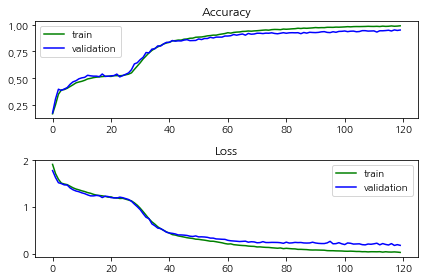

In [32]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [33]:
NUM_DISPLAY = 30

print("{:20}|{:7}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:8} {}".format(question, label, prediction))

질문                  |실제값    |예측값
---------------------------------------
은경이는 어디야 ?          : 복도       복도
필웅이는 어디야 ?          : 화장실      화장실
경임이는 어디야 ?          : 부엌       부엌
경임이는 어디야 ?          : 복도       복도
경임이는 어디야 ?          : 부엌       부엌
경임이는 어디야 ?          : 복도       복도
경임이는 어디야 ?          : 정원       정원
수종이는 어디야 ?          : 복도       복도
경임이는 어디야 ?          : 사무실      정원
수종이는 어디야 ?          : 사무실      부엌
필웅이는 어디야 ?          : 부엌       부엌
필웅이는 어디야 ?          : 정원       정원
수종이는 어디야 ?          : 사무실      사무실
필웅이는 어디야 ?          : 침실       침실
필웅이는 어디야 ?          : 침실       침실
은경이는 어디야 ?          : 부엌       부엌
은경이는 어디야 ?          : 정원       정원
은경이는 어디야 ?          : 부엌       부엌
수종이는 어디야 ?          : 사무실      사무실
은경이는 어디야 ?          : 부엌       복도
필웅이는 어디야 ?          : 복도       복도
은경이는 어디야 ?          : 사무실      사무실
은경이는 어디야 ?          : 사무실      사무실
경임이는 어디야 ?          : 복도       복도
수종이는 어디야 ?          : 침실       침실
경임이는 어디야 ?          : 침실       침실
필웅이는 어디야 ?          : 침실       침실
수종이는

### ckonlpy 사용해보기
토크나이징할 때에 한국어 특성을 고려한 토크나이징을 사용해본다.   
ckonlpy를 이용하여 이전과 동일한 조건으로 실험한다.   
오히려 성능이 안 좋은 것을 알 수 있는데 아마도 이름같은 고유명사들을 형태소로 분리해서 분석하기 때문일 것이다.   
이를 방지하기 위해서는 각각의 고유명사들을 모두 등록해줘야 하는 일이 필요할 것이다.   

In [35]:
from ckonlpy.tag import Twitter
twitter = Twitter()
twitter.add_dictionary('은경이', 'Noun')
twitter.morphs('은경이는 사무실로 갔습니다.')

['은경이', '는', '사무실', '로', '갔습니다', '.']

In [36]:
def tokenize(sent):
    return twitter.morphs(sent)

In [37]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [38]:
print(word2idx)

{'는': 1, '.': 2, '로': 3, '이': 4, '했습니다': 5, '으로': 6, '경': 7, '임': 8, '은경이': 9, '수종': 10, '필웅이': 11, '이동': 12, '가버렸습니다': 13, '뛰어갔습니다': 14, '복귀': 15, '화장실': 16, '정원': 17, '복도': 18, '갔습니다': 19, '사무실': 20, '부엌': 21, '침실': 22, '어디': 23, '야': 24, '?': 25}


In [39]:
vocab_size = len(word2idx) + 1

In [40]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 82
질문의 최대 길이 : 7


In [41]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [42]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [43]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 82) (10000, 7) (10000, 26) (1000, 82) (1000, 7) (1000, 26)


In [45]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

# 스토리를 위한 첫 번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원

# 스토리를 위한 두 번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m, '\n')
print('Input encoded c', input_encoded_c, '\n')
print('Question encoded', question_encoded, '\n')

# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Stories : Tensor("input_3:0", shape=(None, 82), dtype=float32)
Question: Tensor("input_4:0", shape=(None, 7), dtype=float32)
Input encoded m Tensor("sequential_3/Identity:0", shape=(None, 82, 50), dtype=float32) 

Input encoded c Tensor("sequential_4/Identity:0", shape=(None, 82, 7), dtype=float32) 

Question encoded Tensor("sequential_5/Identity:0", shape=(None, 7, 50), dtype=float32) 

Match shape Tensor("activation_2/Identity:0", shape=(None, 82, 7), dtype=float32)
Response shape Tensor("permute_1/Identity:0", shape=(None, 7, 82), dtype=float32)
Answer shape Tensor("concatenate_1/Identity:0", shape=(None, 7, 132), dtype=float32)


In [46]:
import os

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/babi_memory_net/model_c.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 2s 6ms/step - loss: 1.8982 - acc: 0.1771 - val_loss: 1.7263 - val_acc: 0.2610
Epoch 2/120
313/313 [==============================] - 1s 4ms/step - loss: 1.6799 - acc: 0.2660 - val_loss: 1.6063 - val_acc: 0.3200
Epoch 3/120
313/313 [==============================] - 1s 4ms/step - loss: 1.5639 - acc: 0.3412 - val_loss: 1.4992 - val_acc: 0.3730
Epoch 4/120
313/313 [==============================] - 1s 5ms/step - loss: 1.5064 - acc: 0.3681 - val_loss: 1.4695 - val_acc: 0.3870
Epoch 5/120
313/313 [==============================] - 1s 4ms/step - loss: 1.4849 - acc: 0.3763 - val_loss: 1.4647 - val_acc: 0.4090
Epoch 6/120
313/313 [==============================] - 1s 4ms/step - loss: 1.4468 - acc: 0.4067 - val_loss: 1.4182 - val_acc: 0.4490
Epoch 7/120
313/313 [==============================] - 1s 4ms/step - loss: 1.3861 - acc: 0.4594 - val_loss: 1.3271 - val_acc: 0.4910
Epoch 8/120
313/313 [==============================] - 1s 4ms/step - 

313/313 [==============================] - 1s 4ms/step - loss: 0.3431 - acc: 0.8774 - val_loss: 0.8292 - val_acc: 0.7560
Epoch 63/120
313/313 [==============================] - 1s 4ms/step - loss: 0.3340 - acc: 0.8831 - val_loss: 0.8392 - val_acc: 0.7450
Epoch 64/120
313/313 [==============================] - 1s 4ms/step - loss: 0.3349 - acc: 0.8837 - val_loss: 0.8602 - val_acc: 0.7590
Epoch 65/120
313/313 [==============================] - 1s 4ms/step - loss: 0.3173 - acc: 0.8833 - val_loss: 0.8430 - val_acc: 0.7470
Epoch 66/120
313/313 [==============================] - 2s 6ms/step - loss: 0.3148 - acc: 0.8921 - val_loss: 0.8068 - val_acc: 0.7420
Epoch 67/120
313/313 [==============================] - 2s 7ms/step - loss: 0.2976 - acc: 0.8958 - val_loss: 0.8497 - val_acc: 0.7430
Epoch 68/120
313/313 [==============================] - 2s 6ms/step - loss: 0.3020 - acc: 0.8934 - val_loss: 0.8369 - val_acc: 0.7500
Epoch 69/120
313/313 [==============================] - 2s 7ms/step - loss:

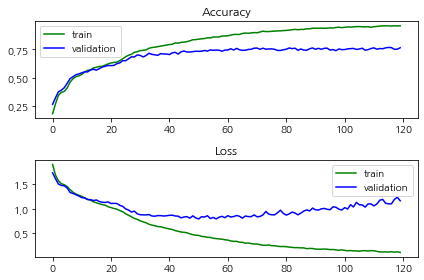

In [47]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [49]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 4ms/step - loss: 1.1594 - acc: 0.7650

 테스트 정확도: 0.7650


## 회고 및 루브릭 평가

### 루브릭 평가 항목
1. 한국어의 특성에 알맞게 전처리가 진행되었다.
	(한국어 특성에 따른 토큰화, 임베딩을 거쳐 데이터셋이 적절히 구성되었다.)
2. 메모리 네트워크가 정상적으로 구현되어 학습이 안정적으로 진행되었다.
	(validation loss가 안정적으로 수렴하는 것을 확인하고 이를 시각화하였다.)
3. 메모리 네트워크를 통해 한국어 bAbI 태스크의 높은 정확도를 달성하였다.
	(추론 태스크의 테스트 정확도가 90% 이상 달성하였다.)

### 평가 항목에 대한 수행
1. 데이터를 토큰화 및 임베딩을 거쳐 데이터셋을 구성하였다. 또한 한국어 특성에 따른 토큰화도 진행을 하였다.
2. validation loss가 안정적으로 수렴하였고 이를 시각화하였다.
3. 추론 태스크의 테스트 정확도가 95%가 되었다.

### 회고

노션에 공지된 꼭 포함이 되어야 할 점
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

---
- **어려웠던 점**    
특별히 어려웠던 점은 없었던 것 같다.

---
- **알아낸 점**    
메모리 네트워크를 구성할 때 기본적으로 LSTM이 이용될 수 있다는 것을 알 수 있었다.


- **모호한 점**    
한국어 특성을 이용하지 않고도 충분히 좋은 성능을 낼 수 있는데 굳이 ckonlpy를 사용하는 이유를 모르겠다.

---
- **시도한 것들**   
ckonlpy를 이용한 것과 이용하지 않은 것을 비교해 볼 수 있었다.

---
- **루브릭 평가 관련 지표**   
제 예상에는 모두 달성되었다고 생각한다. 그 이유는 위에 있는 **평가 항목에 대한 수행**에 나와있다.  
- **자기 다짐** 및 **나의 생각들**      
간단하게 메모리 네트워크에 대해서 구현해 볼 수 있는 기회였다. babi task에 대해서 문제를 해결하였는데 사실 문제의 난이도가 높아 보이지는 않아서 간단하게 해결이 되었던 것 같다. 인간의 지능 중에서 추론하는 능력을 구현하기 위해서는 기억(저장)하는 능력이 필수적인데 이와 관련해서 좀 더 공부를 하면 좋을 것 같다. 